In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Coding data loader

In [3]:
class BatchFeeder:
    """ Simple iterator for feeding a subset of numpy matrix into tf network.
    validation data has same size of mini batch
     Parameter
    ----------------
    X: ndarray
    y: ndarray
    batch_size: mini batch size
    """

    def __init__(self, x_, y_, batch_size, valid=False, ini_random=True):
        """check whether X and Y have the matching sample size."""
        assert len(x_) == len(y_)
        self.n = len(x_)
        self.X = x_
        self.y = y_
        self.index = 0
        # self.base_index = np.arange(len(X))
        if ini_random:
            _ = self.randomize(np.arange(len(x_)))
        if valid:
            self.create_validation(batch_size)
        self.batch_size = batch_size
        self.base_index = np.arange(self.n)
        self.val = None

    def create_validation(self, batch_size):
        self.val = (self.X[-1*int(batch_size):], self.y[-1*int(batch_size):])
        self.X = self.X[:-1*int(batch_size)]
        self.y = self.y[:-1*int(batch_size)]
        self.n = len(self.X)-int(batch_size)

    def next(self):
        if self.index + self.batch_size > self.n:
            self.index = 0
            self.base_index = self.randomize(self.base_index)
        ret_x = self.X[self.index:self.index+self.batch_size]
        ret_y = self.y[self.index:self.index+self.batch_size]
        self.index += self.batch_size
        return ret_x, ret_y

    def randomize(self, index):
        np.random.shuffle(index)
        self.y = self.y[index]
        self.X = self.X[index]
        return index

In [4]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

X = mnist.train._images.reshape(55000,784)
Y = mnist.train._labels
index = np.arange(55000)
np.random.shuffle(index)

train_bf = BatchFeeder(X[index[:54000]], Y[index[:54000]], 128)
valid_bf = BatchFeeder(X[index[54000:]], Y[index[54000:]], 32)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


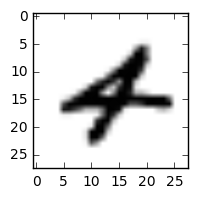

In [5]:
x, y = train_bf.next()
plt.figure(figsize=(2,2))
plt.imshow(x[0].reshape((28,28)), cmap='Greys')
plt.show()

# Coding VAE

In [172]:
class VAE:
    def __init__(self, dimensions, fn=tf.nn.elu, dropout=1.0):
        # Reset all existing tensors
        tf.reset_default_graph()
        
        # Define parameters of the encoder
        self.dimensions = dimensions
        self.fn = fn
        self._lambda = 0.0
        self.learning_rate = 0.001
        self._dropout = 1.0
        self.built = False
        self.sesh = tf.Session()
        self.e = 0
        self.learning_curve = []
        
        # Building the graph
        self.ops = self.build()
        self.sesh.run(tf.global_variables_initializer())
    
    def build(self):
        # Placeholders for input and dropout probs.
        if self.built:
            return -1
        else:
            self.built = True
        x = tf.placeholder(tf.float32, shape=[None, self.dimensions[0]], name="x")
        dropout = tf.placeholder(tf.float32, shape=[], name="dropout_keepprob")
        
        # Fully connected encoder.
        with tf.variable_scope("encoder"):
            dense = x
            for dim in self.dimensions[1:-1]:
                dense = tf.contrib.slim.fully_connected(dense, dim, activation_fn=self.fn)
                dense = tf.contrib.slim.dropout(dense, keep_prob=dropout)
                
        with tf.name_scope("latent"):
            # Latent distribution defined.
            z_mean = tf.contrib.slim.fully_connected(dense, self.dimensions[-1], activation_fn=tf.identity)
            z_logsigma = tf.contrib.slim.fully_connected(dense, self.dimensions[-1], activation_fn=tf.identity)
            
        z = self.sample(z_mean, z_logsigma)
        
        # Fully connected decoder.
        with tf.variable_scope("decoder"):
            dense = z
            for i in range(len(self.dimensions[1:-1])):
                dim = self.dimensions[1:-1][-1*i-1]
                dense = tf.contrib.slim.fully_connected(dense, dim, activation_fn=self.fn)
                dense = tf.contrib.slim.dropout(dense, keep_prob=dropout)
            reconstructed = tf.contrib.slim.fully_connected(dense, self.dimensions[0], activation_fn=tf.nn.sigmoid)
        
        # Defining the loss components.
        rec_loss = self.crossEntropy(reconstructed, x)
        kl_loss = self.kullbackLeibler(z_mean, z_logsigma)
        
        # Regularize weights by l2 if necessary
        with tf.name_scope("l2_regularization"):
            regularizers = [tf.nn.l2_loss(v) for v in tf.trainable_variables() if "weights" in v.name]
            l2_reg = self._lambda * tf.add_n(regularizers)
            
        # Define cost as the sum of KL and reconstrunction ross with BinaryXent.
        with tf.name_scope("cost"):
            # average over minibatch
            cost = tf.reduce_mean(rec_loss + kl_loss, name="vae_cost")
            cost += l2_reg
        
        # Defining optimization procedure.
        with tf.name_scope("Adam_optimizer"):
            optimizer = tf.train.AdamOptimizer(self.learning_rate)
            tvars = tf.trainable_variables()
            grads_and_vars = optimizer.compute_gradients(cost, tvars)
            clipped = [(tf.clip_by_value(grad, -5, 5), tvar) for grad, tvar in grads_and_vars]
            train = optimizer.apply_gradients(clipped, name="minimize_cost")
            
        # Graph for reconstrunction from latent input.
        # Variables are shared with the regular decoder. Hence, it will be trained simultaneously.
        with tf.variable_scope("decoder", reuse=True):
            z_ = tf.placeholder_with_default(tf.random_normal([1, self.dimensions[-1]]),
                                            shape=[None, self.dimensions[-1]],
                                            name="latent_input")
            dense = z_
            for i in range(len(self.dimensions[1:-1])):
                dim = self.dimensions[1:-1][-1*i-1]
                dense = tf.contrib.slim.fully_connected(dense, dim, activation_fn=self.fn)
                dense = tf.contrib.slim.dropout(dense, keep_prob=dropout)
                
            reconstructed_ = tf.contrib.slim.fully_connected(dense, self.dimensions[0], activation_fn=tf.nn.sigmoid)
            
        # Exporting out the operaions as dictionary
        return dict(
            dropout_keepprob = dropout,
            x = x,  
            z_mean = z_mean, 
            z_logsigma = z_logsigma,
            z = z,
            latent_input = z_,
            reconstructed = reconstructed,
            reconstructed_ = reconstructed_,
            rec_loss = rec_loss,
            kl_loss = kl_loss,
            cost = cost,
            train = train
        )
    
    # Closing session
    def close(self):
        self.sesh.close()
    
    # ReparameterizationTrick
    def sample(self, mu, log_sigma):
        with tf.name_scope("sample_reparam"):
            epsilon = tf.random_normal(tf.shape(log_sigma), name="0mean1varGaus")
            return mu + epsilon * tf.exp(log_sigma)

    # Binary cross-entropy (Adapted from online source)
    def crossEntropy(self, obs, actual, offset=1e-7):
        with tf.name_scope("BinearyXent"):
            obs_ = tf.clip_by_value(obs, offset, 1 - offset)
            return -tf.reduce_sum(actual * tf.log(obs_) +
                                  (1 - actual) * tf.log(1 - obs_), 1)
        
    # KL divergence between Gaussian with mu and log_sigma, q(z|x) vs 0-mean 1-variance Gaussian p(z).
    def kullbackLeibler(self, mu, log_sigma):
        with tf.name_scope("KLD"):
            return -0.5 * tf.reduce_sum(1 + 2 * log_sigma - mu**2 - tf.exp(2 * log_sigma), 1)
    
    # training procedure.
    def train(self, X, epochs, valid=None):
        # Making the saver object.
        saver = tf.train.Saver()
        
        # Defining the number of batches per epoch
        batch_num = int(np.ceil(X.n*1.0/X.batch_size))
        if valid != None:
            val_batch_num = int(np.ceil(valid.n*1.0/valid.batch_size))
        
        e = 0
        while e < epochs:
            epoch_cost = {"kld":[], "rec":[], "cost":[], "validcost":[]}
            for i in range(batch_num):
                
                #Training happens here.
                batch = X.next()
                feed_dict = {self.ops["x"]: batch[0], self.ops["dropout_keepprob"]: self._dropout}
                ops_to_run = [self.ops["reconstructed"], self.ops["cost"],\
                              self.ops["kl_loss"], self.ops["rec_loss"], self.ops["train"]]
                reconstruction, cost, kld, rec, _= self.sesh.run(ops_to_run, feed_dict)
                epoch_cost["kld"].append(np.mean(kld))
                epoch_cost["rec"].append(np.mean(rec))
                epoch_cost["cost"].append(cost)
            
            if valid != None:
                for i in range(val_batch_num):
                    batch = valid.next()
                    feed_dict = {self.ops["x"]: batch[0], self.ops["dropout_keepprob"]: 1.0}
                    cost = self.sesh.run(self.ops["cost"], feed_dict)
                    epoch_cost["validcost"].append(cost)
            self.e+=1
            e+= 1
                
            print "Epoch:"+str(self.e), "train_cost:", np.mean(epoch_cost["cost"]),
            if valid != None: print "valid_cost:", np.mean(epoch_cost["validcost"]),
            print "(", np.mean(epoch_cost["kld"]), np.mean(epoch_cost["rec"]), ")"
            self.learning_curve.append(epoch_cost)
    
    # Encode examples
    def encode(self, x):
        feed_dict = {self.ops["x"]: x, self.ops["dropout_keepprob"]: 1.0}
        return self.sesh.run([self.ops["z_mean"], self.ops["z_logsigma"]], feed_dict=feed_dict)

    # Decode latent examples. Other_wise, draw from N(0,1)
    def decode(self, zs=None):
        # (np.array | tf.Variable) -> np.array
        feed_dict = dict()
        if zs is not None:
            feed_dict = {self.ops["latent_input"]: zs, self.ops["dropout_keepprob"]: 1.0}
        return self.sesh.run(self.ops["reconstructed_"], feed_dict)

In [175]:
v = VAE([784, 256, 128, 64, 2])

In [176]:
v.train(train_bf, 40, valid_bf)

Epoch:1 train_cost: 192.399 valid_cost: 169.989 ( 5.08006 187.319 )
Epoch:2 train_cost: 169.255 valid_cost: 164.592 ( 5.02093 164.234 )
Epoch:3 train_cost: 163.265 valid_cost: 159.277 ( 5.16301 158.102 )
Epoch:4 train_cost: 159.462 valid_cost: 155.88 ( 5.31836 154.144 )
Epoch:5 train_cost: 156.13 valid_cost: 154.519 ( 5.49179 150.638 )
Epoch:6 train_cost: 153.518 valid_cost: 150.494 ( 5.71176 147.806 )
Epoch:7 train_cost: 151.576 valid_cost: 148.753 ( 5.83415 145.742 )
Epoch:8 train_cost: 149.951 valid_cost: 149.711 ( 5.95915 143.992 )
Epoch:9 train_cost: 149.04 valid_cost: 146.583 ( 5.98756 143.053 )
Epoch:10 train_cost: 148.091 valid_cost: 146.479 ( 6.06896 142.022 )
Epoch:11 train_cost: 147.043 valid_cost: 146.592 ( 6.14452 140.899 )
Epoch:12 train_cost: 146.666 valid_cost: 145.521 ( 6.193 140.473 )
Epoch:13 train_cost: 145.52 valid_cost: 145.131 ( 6.23195 139.288 )
Epoch:14 train_cost: 145.083 valid_cost: 142.923 ( 6.28244 138.8 )
Epoch:15 train_cost: 144.525 valid_cost: 143.834 ( 

# Image generation across 2d space.

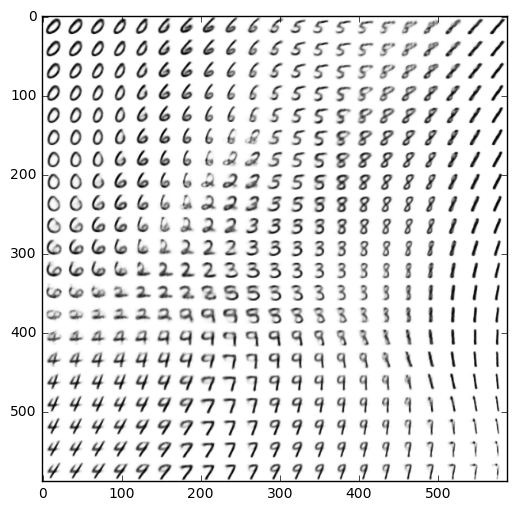

In [178]:
num_image = 20
_range = (-2,2)
latent_inputs = []
for i in range(num_image+1):
    for j in range(num_image+1):
        latent_inputs.append([_range[0]+(_range[1]-_range[0])*1.0/num_image*i,\
                              _range[0]+(_range[1]-_range[0])*1.0/num_image*j])
        
reconstructed = v.decode(latent_inputs)
result = np.zeros(((num_image+1)*28, (num_image+1)*28))
count = 0
for i in reconstructed:
    temp = i.reshape((28,28))
    result[count/(num_image+1)*28:(count/(num_image+1)+1)*28,\
           count%(num_image+1)*28:(count%(num_image+1)+1)*28] = temp
    count += 1

plt.figure(figsize=(6,6))
plt.imshow(result, cmap='Greys')
plt.show()

# Image completion

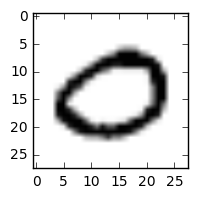

In [6]:
test = valid_bf.next()[0][0].reshape((28,28))
plt.figure(figsize=(2,2))
plt.imshow(test, cmap="Greys")
plt.show()

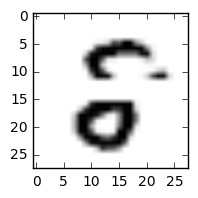

In [212]:
#test[12:16, :] = 0
plt.figure(figsize=(2,2))
plt.imshow(test, cmap="Greys")
plt.show()

In [213]:
latent = v.encode(test.reshape((1,784)))[0]
reconstructed = v.decode(latent)[0].reshape((28,28))

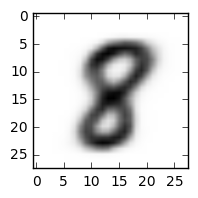

In [215]:
plt.figure(figsize=(2,2))
plt.imshow(reconstructed, cmap="Greys")
plt.show()